In [2]:
import json
import geopandas as gp
from shapely.geometry import Polygon, Point, shape
from shapely.ops import transform
import pyproj
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
# from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline 

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
!pwd

/Users/manya/Desktop/Personal/UW/Study-Notes/Quarter4/data-512-project


## ESRI JSON Data Acquistion and Processing 

In [3]:
with open("/Users/manya/Desktop/Personal/UW/Study-Notes/Quarter4/DATA_512_Assignments/data-512-project/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json", "r") as f:
    data = json.load(f)

In [ ]:
# Extract features from the JSON data
features = data.get('features', [])

# Create lists to hold geometries and properties
geometries = []
properties = []

for feature in features:
    # Get geometry data
    geometry = feature.get('geometry')
    if geometry and 'rings' in geometry:
        rings = geometry['rings']
        if rings:
            # Convert the first ring to a Polygon
            polygon = Polygon(rings[0])
            if polygon.is_valid:
                geometries.append(polygon)
                properties.append(feature['attributes'])

# Create a GeoDataFrame if there are valid geometries
if geometries:
    # Creating the GeoDataFrame
    full_fires = gp.GeoDataFrame(properties, geometry=geometries, crs="ESRI:102008")  # Use the appropriate CRS from your JSON

    # Project to mercator for distances
    full_fires = full_fires.to_crs("EPSG:3857")

In [ ]:
full_fires.columns

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')

In [ ]:
# Finding all fires with polygons present within a 650 mile radius // considering entire poylgon not just centroid

# Omaha, NE (lon,lat) in mercator projection and epsg 4326
omaha_point_mercator = Point(-10679713.647979682, 5050561.887240941)
omaha_point = Point(-95.9375, 41.258611)

# Create the buffer around the point (650 miles) ; 1 mile is approximately 1609.34 meters
buffer = omaha_point_mercator.buffer(650 * 1609.34)

# Filter geometries that fall within the buffer
filtered_fires = full_fires[(full_fires['geometry'].intersects(buffer)) & (full_fires['Fire_Year']>=1961) & (full_fires['Fire_Year']<=2021)]

In [ ]:
print(f"Found {filtered_fires.shape[0]} fires in Omaha, NE from year 1800 onwards.")

Found 13641 fires in Omaha, NE from year 1800 onwards.


In [ ]:
# Filtering out relevant columns

fires = filtered_fires[["Fire_Year","GIS_Acres","Listed_Fire_Types","Listed_Fire_Codes","Listed_Fire_Dates","geometry"]]

In [ ]:
# Function to extract start, control and end date of a fire wherever possible 

def extract_dates(type,x):
    try:
        if type == "Discovery":
            if "Start" in x.split("|")[0] or "Discovery" in x.split("|")[0]:
                return x.split("|")[0].split(": ")[1].split(" ")[0]
            else:
                return pd.NaT
        elif type == "Out":
            if "Out" in x.split("|")[2] or "End" in x.split("|")[2]:
                return x.split("|")[2].split(": ")[1].split(" ")[0]
            else:
                return pd.NaT
        else:
            if "Upload" in x.split("|")[1]:
                return pd.NaT
            else:
                return x.split("|")[1].split(": ")[1].split(" ")[0]
    except:
        return pd.NaT

fires.loc[:,'Discovery_Date'] = fires.loc[:,'Listed_Fire_Dates'].apply(lambda x: extract_dates("Discovery",x))
fires.loc[:,"Control_Date"] = fires.loc[:,'Listed_Fire_Dates'].apply(lambda x: extract_dates("Control",x))
fires.loc[:,"Out_Date"] = fires.loc[:,'Listed_Fire_Dates'].apply(lambda x: extract_dates("Out",x))

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [ ]:
# Creating fire duration column where duration = out/control date - discovery date. Control date used when Out Date not available
fires['Duration'] = fires.apply(
    lambda row: (
        (pd.to_datetime(row['Out_Date']) if pd.notna(row['Out_Date']) else pd.to_datetime(row['Control_Date'])) - pd.to_datetime(row['Discovery_Date'])
        if pd.notna(row['Discovery_Date'])
        else pd.NaT
    ),
    axis=1
)

fires['Duration'] = fires['Duration'].apply(lambda x: x.days if isinstance(x, pd.Timedelta) else pd.NaT)

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# Find centroid of fire polygons and measure euclidean distance from centroid to omaha's (lon, lat)
# Convert everything into meter**2

fires.loc[:,"fire_centroid"] = fires.loc[:,"geometry"].apply(lambda x: x.centroid)
fires.loc[:,"distance_euclidean_meters"] = fires.loc[:,"fire_centroid"].distance(omaha_point_mercator)
fires.loc[:,'distance_miles'] = fires.loc[:,"distance_euclidean_meters"] / 1609.34
fires.loc[:,"area_m2"] = fires.loc[:,"GIS_Acres"] * 4046.86

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

## Smoke Estimate Creation

#### We create 2 type of smoke estimates based on information provided and try to test which one performs better.

1. Smoke_estimate = Area burned (m2) / [Distance of fire from Omaha city center (m)]^2
2. Smoke_estimate_dur = Smoke_estimate * Duration of Fire

While duration plays a crucial role in determining how much smoke a city experiences, it is noted that the start and end date provided are unreliable. This process of testing 2 estimate is purely experimental. 

In [ ]:
fires.loc[:,"smoke_estimate"] = (fires.loc[:,"area_m2"]) / ((fires.loc[:,"distance_euclidean_meters"])**2)

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
fires.loc[:,'smoke_estimate_dur'] = fires.apply(lambda row: row['smoke_estimate'] 
                                      if pd.isna(row['Duration']) or row['Duration'] == 0 else row['smoke_estimate'] * row['Duration'], axis=1)

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
fires.to_csv("omaha_fires.csv")


In [ ]:
annual_estimate = fires[["Fire_Year","smoke_estimate","smoke_estimate_dur"]].groupby("Fire_Year").agg(func="sum")

In [ ]:
# Taking log for larger values
annual_estimate.loc[:,"log_smoke_estimate"]= abs(np.log(annual_estimate.loc[:,'smoke_estimate']))
annual_estimate.loc[:,"log_smoke_estimate_dur"] = abs(np.log(annual_estimate.loc[:,"smoke_estimate_dur"]))

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
annual_estimate.head(5)

,smoke_estimate,smoke_estimate_dur,log_smoke_estimate,log_smoke_estimate_dur
Fire_Year,,,,
1961,7.347193e-06,8.790886e-05,11.821192,9.339210
1962,1.820180e-10,5.460540e-10,22.426916,21.328303
1963,3.833020e-06,5.752778e-06,12.471858,12.065828
1964,7.037862e-05,1.829810e-03,9.561621,6.303543
1965,3.150155e-04,6.057429e+00,8.062889,1.801285


In [18]:
annual_estimate.to_csv("smoke_estimates.csv")

## Getting AQI data and creating suitable AQI estimate

In [19]:
# Dataframe of acquired AQI

with open("intermediate_data_files/particulate_aqi.json",'r') as f:
    particulate_aqi = json.load(f)

with open("intermediate_data_files/gaseous_aqi.json",'r') as f:
    gaseous_aqi = json.load(f)

In [20]:
yearly_particulate = {}
for year, value in particulate_aqi.items():
    data = value['Data']
    try:
        df = gp.GeoDataFrame(data)[['date_local','aqi','parameter','latitude','longitude','parameter_code']]
        grouped_df = df.groupby(['date_local','parameter']).agg(func='max').reset_index() # Take max values per pollutant for given day
        daily_avg_aqi = grouped_df.groupby('date_local')['aqi'].mean().reset_index() # Average AQI per day accounting for all pollutants
        yearly_particulate[year] = daily_avg_aqi['aqi'].mean() # Avg AQI aggregated for fire season (presented as yearly)
    except:
        yearly_particulate[year] = np.nan

In [21]:
yearly_gaseous = {}
for year, value in gaseous_aqi.items():
    data = value['Data']
    try:
        df = gp.GeoDataFrame(data)[['date_local','aqi','parameter','latitude','longitude','parameter_code']]
        grouped_df = df.groupby(['date_local','parameter']).agg(func='max').reset_index() # Take max values per pollutant for given day
        daily_avg_aqi = grouped_df.groupby('date_local')['aqi'].mean().reset_index() # Average AQI per day accounting for all pollutants
        yearly_gaseous[year] = daily_avg_aqi['aqi'].mean() # Avg AQI aggregated for fire season (presented as yearly)
    except:
        yearly_gaseous[year] = np.nan

In [22]:
yearly_gaseous_df = pd.DataFrame(list(yearly_gaseous.items()),columns=['year', 'gas_aqi_value'])
yearly_particulate_df = pd.DataFrame(list(yearly_particulate.items()),columns=['year', 'particulate_aqi_value'])
aqi_data = yearly_gaseous_df.merge(yearly_particulate_df,on='year',how='left')

In [23]:
# Building Final AQI as a weighted combination of gaseous and particulate pollutants.

aqi_data['final_aqi'] = aqi_data.apply(lambda row: row['gas_aqi_value'] if pd.isna(row['particulate_aqi_value']) 
                           else (0.3* row['gas_aqi_value'] + 0.7* row['particulate_aqi_value']), axis=1)

In [25]:
annual_estimate = annual_estimate.reset_index()
annual_estimate['Fire_Year'] = annual_estimate['Fire_Year'].astype(str)

In [26]:
annual_estimate.head(2)

,Fire_Year,smoke_estimate,smoke_estimate_dur,log_smoke_estimate,log_smoke_estimate_dur
0,1961,7.347193e-06,8.790886e-05,11.821192,9.339210
1,1962,1.820180e-10,5.460540e-10,22.426916,21.328303


In [27]:
aqi_data.head(2)

,year,gas_aqi_value,particulate_aqi_value,final_aqi
0,1970,NaN,NaN,NaN
1,1971,NaN,NaN,NaN


/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_35053/2865128174.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(annual_estimate['Fire_Year'], rotation=45, fontsize=10)


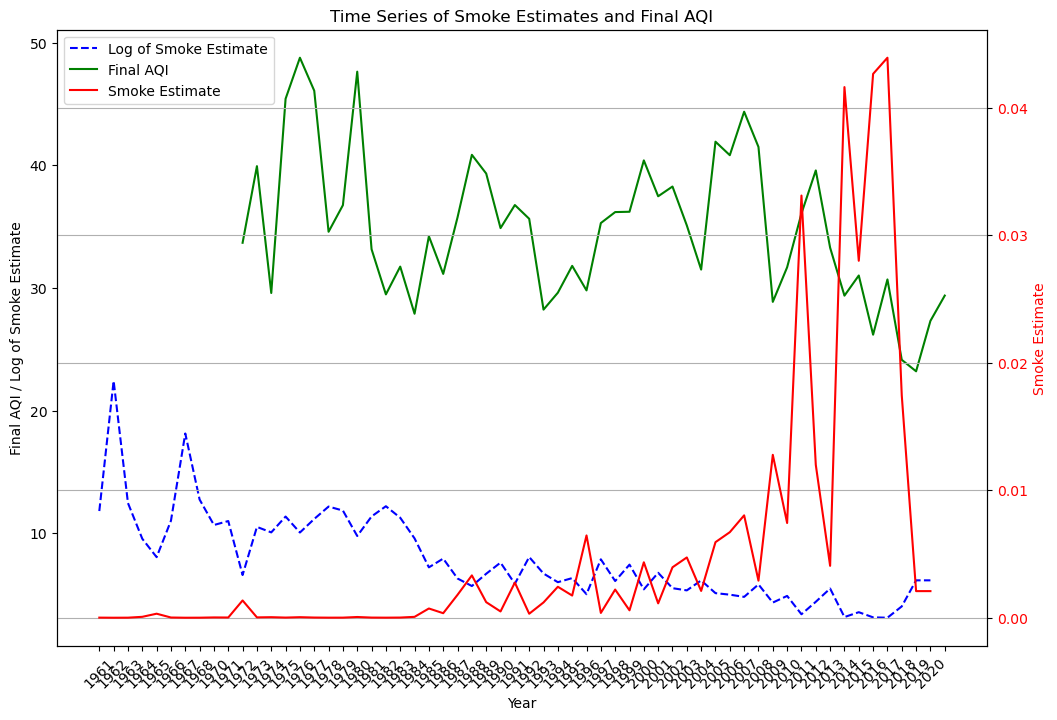

In [28]:
# Set up the figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot on the primary y-axis
line1, = ax1.plot(annual_estimate['Fire_Year'], annual_estimate['log_smoke_estimate'], label='Log of Smoke Estimate', color='b', linestyle='--')
line2, = ax1.plot(aqi_data['year'], aqi_data['final_aqi'], label='Final AQI', color='g')

# Label for the primary y-axis
ax1.set_ylabel('Final AQI / Log of Smoke Estimate', color='black')
ax1.set_xlabel('Year')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis for smoke_estimate
ax2 = ax1.twinx()

# Plot on the secondary y-axis
line3, = ax2.plot(annual_estimate['Fire_Year'], annual_estimate['smoke_estimate'], label='Smoke Estimate', color='r')
ax2.set_ylabel('Smoke Estimate', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a single legend that includes all lines
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# ax1.set_xticks(annual_estimate['Fire_Year'][::5])  # Show every 5th year for better visibility
ax1.set_xticklabels(annual_estimate['Fire_Year'], rotation=45, fontsize=10)
# Add a title and grid
plt.title('Time Series of Smoke Estimates and Final AQI')
plt.grid(True)

# Show the plot
plt.show()

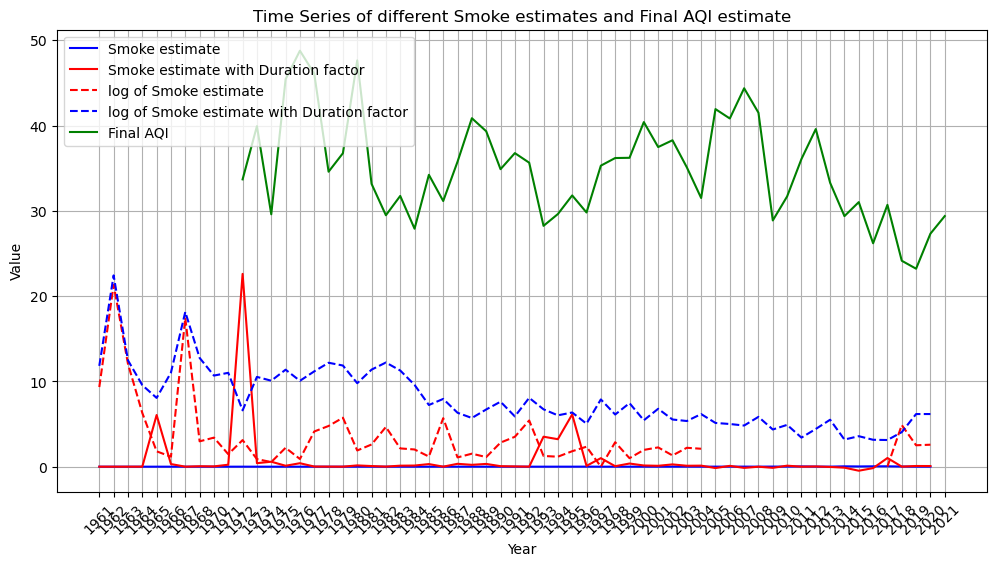

In [29]:
# Plotting smoke_estimate, smoke_estimate_dur, both their logs and final_aqi as timeseries

""" ChatGPT-4o Prompt: "Help produce a time series plot with 3 lines, 
2 of which are columns in dataframe_1 and 1 is a column in dataframe_2" """

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the normalized columns from annual_estimate DataFrame
plt.plot(annual_estimate['Fire_Year'], annual_estimate['smoke_estimate'], label='Smoke estimate', color='b')
plt.plot(annual_estimate['Fire_Year'], annual_estimate['smoke_estimate_dur'], label='Smoke estimate with Duration factor', color='r')
plt.plot(annual_estimate['Fire_Year'], annual_estimate['log_smoke_estimate_dur'], label='log of Smoke estimate', color='r', linestyle='--')
plt.plot(annual_estimate['Fire_Year'], annual_estimate['log_smoke_estimate'], label='log of Smoke estimate with Duration factor', color='b', linestyle='--')

# Plot the normalized column from aqi_data DataFrame
plt.plot(aqi_data['year'], aqi_data['final_aqi'], label='Final AQI', color='g')

# Set plot labels
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Time Series of different Smoke estimates and Final AQI estimate')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.show()

In [30]:
# To find best correlation between estimates
ae = annual_estimate.copy()
ae = ae.rename({'Fire_Year':"year"},axis=1)

combined_data = pd.merge(ae, aqi_data, on='year', how='inner')
combined_data.columns

Index(['year', 'smoke_estimate', 'smoke_estimate_dur', 'log_smoke_estimate',
       'log_smoke_estimate_dur', 'gas_aqi_value', 'particulate_aqi_value',
       'final_aqi'],
      dtype='object')

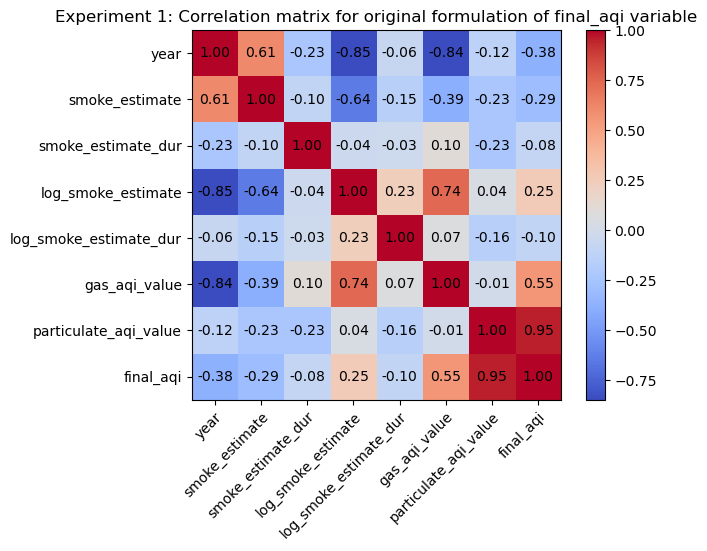

In [31]:
"""Result of Google AI Overview from Google Search: plotting correlation matrix in python pyplot"""

corr_matrix = combined_data.corr()
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the correlation matrix
im = ax.imshow(corr_matrix, cmap='coolwarm')

# Set the tick labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.columns)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Annotate each cell with the correlation coefficient value
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                ha="center", va="center", color="black")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.title("Experiment 1: Correlation matrix for original formulation of final_aqi variable")
plt.show()

### Observations and Modifications

We observe that 'gas_aqi_value' and a strong positive correlation to the 'log_smoke_estimate
variable. This is further corroborated by the weak inverse relation between 'gas_aqi_value' and 'smoke_estimate', although it is interesting to note that 'smoke_estimate' and 'log_smoke_estimate' aren't closely related either. This could be due to the range of values of smoke estimates being very large, from magitude 1e-10 all the way to e.

This observation indicates that if 'gas_aqi_value' contributes more to the formulation of the 'final_aqi' estimate, the AQI estimate would be more closely related to 'log_smoke_estimate' We test this in the following section. 

In [32]:
# Building Final AQI as a weighted combination of gaseous and particulate pollutants. [REFORMULATED]

aqi_data['final_aqi'] = aqi_data.apply(lambda row: row['gas_aqi_value'] if pd.isna(row['particulate_aqi_value']) 
                           else (0.6* row['gas_aqi_value'] + 0.4* row['particulate_aqi_value']), axis=1)

In [33]:
# To find best correlation between estimates
ae = annual_estimate.copy()
ae = ae.rename({'Fire_Year':"year"},axis=1)

combined_data = pd.merge(ae, aqi_data, on='year', how='inner')
combined_data.columns

Index(['year', 'smoke_estimate', 'smoke_estimate_dur', 'log_smoke_estimate',
       'log_smoke_estimate_dur', 'gas_aqi_value', 'particulate_aqi_value',
       'final_aqi'],
      dtype='object')

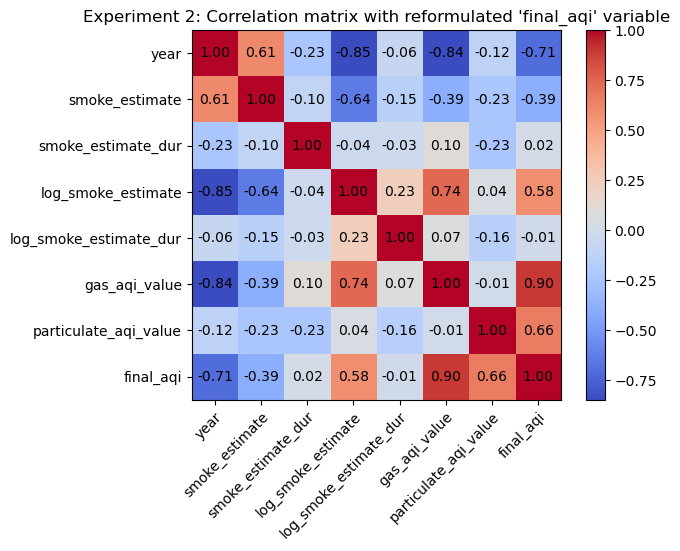

In [34]:
"""Result of Google AI Overview from Google Search: plotting correlation matrix in python pyplot"""

corr_matrix = combined_data.corr()
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the correlation matrix
im = ax.imshow(corr_matrix, cmap='coolwarm')

# Set the tick labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.columns)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Annotate each cell with the correlation coefficient value
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                ha="center", va="center", color="black")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.title("Experiment 2: Correlation matrix with reformulated 'final_aqi' variable")
plt.show()

Clearly, the reformulated 'final_aqi' estimate is more closely related to 'log_smoke_estimate'. The correlation of 0.58 between the two is indicative of a moderate relationship between the two variables, which means that variation in one shows some effect in the value of the other, but doesn't fully explain the variation in the other and they do not change exactly linearly.

## Building a Predictive Model

We will test out the following 2 time series forecasting to get the relatively best model of the lot. 

1. Meta's Prophet model for time series forecasting on "log_smoke_estimates"
2. Exponential Smoothing using "log_smoke_estimates"

Results: Personally, I found the Prophet model predictions to be slightly more reliable. Both models show a declining trend but it seems like the Prophet model is less sensitive to sudden jumps, erratic data and noise. 

##### EDIT: all "log_smoke_estimate" variables were replaced by "smoke_estimate" variable after reconsidering the best estimate. You can simply swap the variables to suit your analysis.

In [35]:
smoke_estimates = annual_estimate[["Fire_Year","smoke_estimate","log_smoke_estimate"]]
smoke_estimates.columns

Index(['Fire_Year', 'smoke_estimate', 'log_smoke_estimate'], dtype='object')

01:58:25 - cmdstanpy - INFO - Chain [1] start processing
01:58:25 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


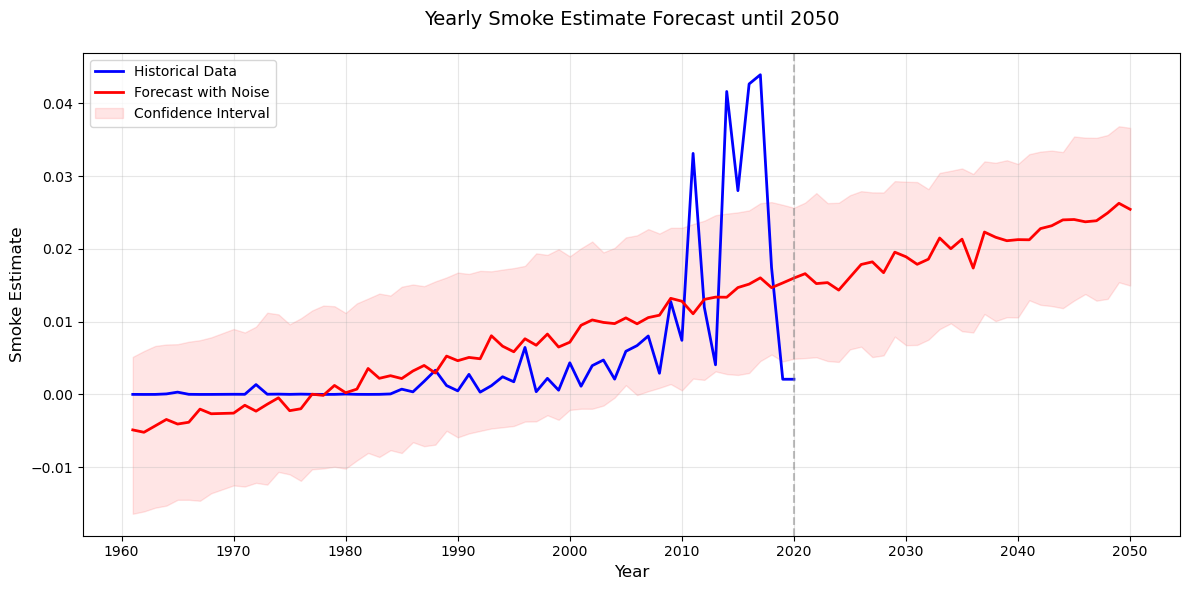

In [38]:
"""Update: older approach used for analysis is contained under Model Approach 1. 
This version is faster and uses the Prophet model to generate smoke_estimate forecasts with random noise included.
Recommend using this for further analysis."""

# Convert the data to Prophet format
df = smoke_estimates[['Fire_Year', 'smoke_estimate']].rename(columns={'Fire_Year': 'ds', 'smoke_estimate': 'y'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y')

# Create and fit the Prophet model
model = Prophet(yearly_seasonality=True)
model.fit(df)

# Create future dates (yearly instead of monthly)
future_periods = 2050 - df['ds'].dt.year.max()
future = model.make_future_dataframe(periods=future_periods, freq='Y')

# Generate forecast
forecast = model.predict(future)

# Add random noise
np.random.seed(42)
noise = np.random.normal(0, forecast['yhat'].std() * 0.1, size=len(forecast))
forecast['yhat_with_noise'] = forecast['yhat'] + noise

# Plot with improvements
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='blue', linewidth=2)
plt.plot(forecast['ds'], forecast['yhat_with_noise'], 
         label='Forecast with Noise', color='red', linewidth=2)
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'], 
                 color='red', 
                 alpha=0.1,
                 label='Confidence Interval')

# Enhance the plot
plt.xlabel('Year', fontsize=12)
plt.ylabel('Smoke Estimate', fontsize=12)
plt.title('Yearly Smoke Estimate Forecast until 2050', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, loc='upper left')

# Add vertical line to separate historical and forecast
current_year = df['ds'].max()
plt.axvline(x=current_year, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Older Version/Approach: Model Approach 1 

In [39]:
smoke_estimates =smoke_estimates.set_index('Fire_Year')
train_data = smoke_estimates[:int(len(smoke_estimates) * 0.8)]
test_data = smoke_estimates[int(len(smoke_estimates) * 0.8):]

In [40]:
# Assuming `df` is your dataframe with 'Fire_Year' and 'smoke_estimate' or 'log_smoke_estimate'
log_df_prophet = smoke_estimates.reset_index()[['Fire_Year', 'smoke_estimate']].rename(columns={'Fire_Year': 'ds', 'smoke_estimate': 'y'})

# Convert the year to a datetime format so Prophet can work with it
log_df_prophet['ds'] = pd.to_datetime(log_df_prophet['ds'], format='%Y')

In [41]:
log_model = Prophet(interval_width=0.9, yearly_seasonality=False)
log_model.fit(log_df_prophet)

01:58:42 - cmdstanpy - INFO - Chain [1] start processing


01:58:42 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Generate future dates for the next 25 years
log_future = log_model.make_future_dataframe(periods=30, freq='Y')
log_forecast = log_model.predict(log_future)

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


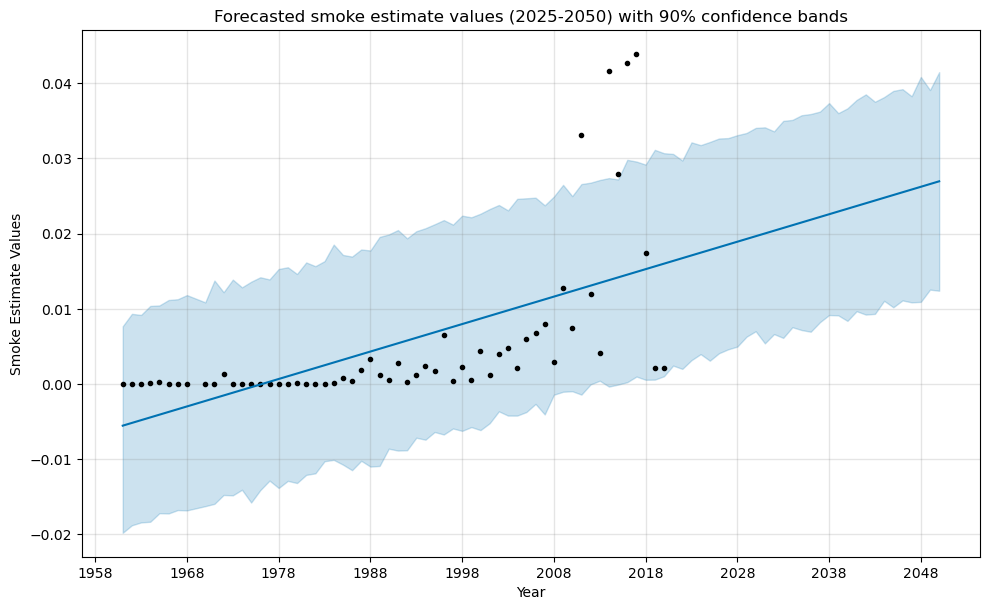

In [43]:
# Plot the forecast
log_fig = log_model.plot(log_forecast)
plt.title("Forecasted smoke estimate values (2025-2050) with 90% confidence bands")
plt.xlabel('Year')
plt.ylabel("Smoke Estimate Values")
plt.show()

In [60]:
log_forecast.to_csv("forecasted-smoke_estimates.csv")

## Model Approach 2: Exponential Smoothing

Edit: Replace "log_smoke_estimate" variable with "smoke_estimate variable" per your needs.

In [1]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


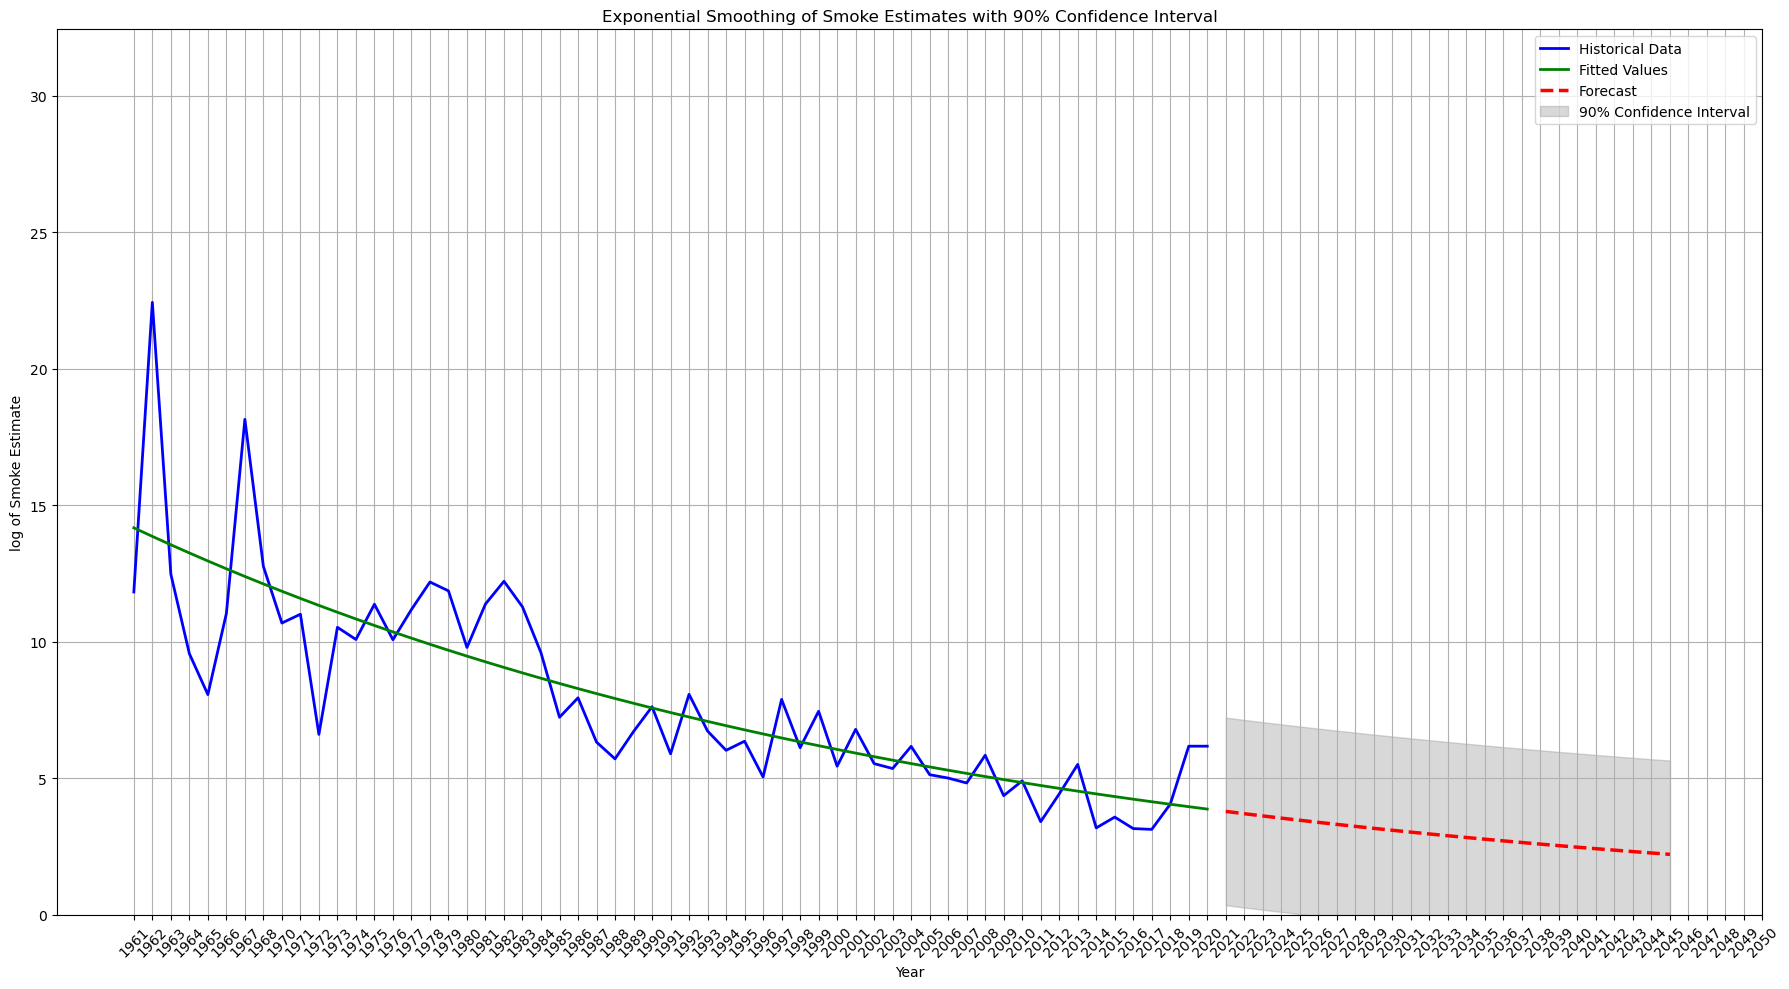

In [185]:
"""ChatGPT prompt: Modify my code to 
1. Give me 90% confidence bands around predictions
2. Have all years labelled from 1960 to 2050"""

# Assuming you have a DataFrame called df with columns ['Fire_Year', 'log_smoke_estimate']
df = smoke_estimates.reset_index().sort_values(by='Fire_Year')
df.set_index('Fire_Year', inplace=True)

# Fit the model with no seasonality
model = ExponentialSmoothing(df['log_smoke_estimate'], trend='add', seasonal=None, damped_trend=True)
fit_model = model.fit()

# Forecast for 25 years
forecast_periods = 25
forecast = fit_model.forecast(steps=forecast_periods)

# Calculate standard deviation of residuals for confidence interval approximation
residuals = df['log_smoke_estimate'] - fit_model.fittedvalues
std_dev = residuals.std()

# Calculate the 90% confidence interval bounds (1.645 is the z-score for 90% confidence)
upper_bound = forecast + (1.645 * std_dev)
lower_bound = forecast - (1.645 * std_dev)

# Plotting
plt.figure(figsize=(18, 10))
years = list(df.index) + [f'20{i}' for i in range(21,51)]  # Set x-ticks every 10 years to reduce overcrowding

# Plot the original data, fitted values, and forecast
plt.plot(df.index, df['log_smoke_estimate'], label='Historical Data', color='blue', linewidth=2)
plt.plot(fit_model.fittedvalues.index, fit_model.fittedvalues, color='green', label='Fitted Values', linewidth=2)
plt.plot(forecast.index, forecast, color='red', linestyle='--', label='Forecast', linewidth=2.5)

# Plot the confidence intervals
plt.fill_between(forecast.index, lower_bound, upper_bound, color='gray', alpha=0.3, label='90% Confidence Interval')

# Set the x-ticks to include all years from 1960 to 2050 (step by 10 to avoid clutter)
plt.xticks(ticks=years, rotation=45)

# Improve y-axis range by allowing more room above the maximum value
plt.ylim([0, max(df['log_smoke_estimate'].max(), forecast.max()) + 10])

# Add labels and title
plt.xlabel('Year')
plt.ylabel('log of Smoke Estimate')
plt.title('Exponential Smoothing of Smoke Estimates with 90% Confidence Interval')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust the padding between and around subplots.

plt.show()


In [ ]:
"""ChatGPT prompt: Modify my code to 
1. Give me 90% confidence bands around predictions
2. Have all years labelled from 1960 to 2050"""

# Assuming you have a DataFrame called df with columns ['Fire_Year', 'smoke_estimate']
df = smoke_estimates.reset_index().sort_values(by='Fire_Year')
df.set_index('Fire_Year', inplace=True)

# Fit the model with no seasonality
model = ExponentialSmoothing(df['smoke_estimate'], trend='add', seasonal=None, damped_trend=True)
fit_model = model.fit()

# Forecast for 25 years
forecast_periods = 25
forecast = fit_model.forecast(steps=forecast_periods)

# Calculate standard deviation of residuals for confidence interval approximation
residuals = df['smoke_estimate'] - fit_model.fittedvalues
std_dev = residuals.std()

# Calculate the 90% confidence interval bounds (1.645 is the z-score for 90% confidence)
upper_bound = forecast + (1.645 * std_dev)
lower_bound = forecast - (1.645 * std_dev)

# Plotting
plt.figure(figsize=(18, 10))
years = list(df.index) + [f'20{i}' for i in range(21,51)]  # Set x-ticks every 10 years to reduce overcrowding

# Plot the original data, fitted values, and forecast
plt.plot(df.index, df['smoke_estimate'], label='Historical Data', color='blue', linewidth=2)
plt.plot(fit_model.fittedvalues.index, fit_model.fittedvalues, color='green', label='Fitted Values', linewidth=2)
plt.plot(forecast.index, forecast, color='red', linestyle='--', label='Forecast', linewidth=2.5)

# Plot the confidence intervals
plt.fill_between(forecast.index, lower_bound, upper_bound, color='gray', alpha=0.3, label='90% Confidence Interval')

# Set the x-ticks to include all years from 1960 to 2050 (step by 10 to avoid clutter)
plt.xticks(ticks=years, rotation=45)

# Improve y-axis range by allowing more room above the maximum value
# plt.ylim([0, max(df['smoke_estimate'].max(), forecast.max()) + 10])

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('Exponential Smoothing of Smoke Estimates with 90% Confidence Interval')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust the padding between and around subplots.

plt.show()

## Visualizations

1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.
2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.
3. Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.

#### Visualization 1: Histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city with a distance cut-off as specified in Step 1.

In [36]:
# Finding all fires with polygons present within a 1800 mile radius // considering entire poylgon not just centroid

# Create the buffer around the point (650 miles) ; 1 mile is approximately 1609.34 meters
buffer1800 = omaha_point_mercator.buffer(1800 * 1609.34)

# Filter geometries that fall within the buffer
filtered_fires1800 = full_fires[(full_fires['geometry'].intersects(buffer1800)) & (full_fires['Fire_Year']>=1961) & (full_fires['Fire_Year']<=2021)]

print(f"Found {filtered_fires1800.shape[0]} fires within 1800 miles of Omaha, NE.")

Found 98695 fires within 1800 miles of Omaha, NE.


In [38]:
fires1800 = filtered_fires1800[["Fire_Year","GIS_Acres","Listed_Fire_Types","Listed_Fire_Codes","Listed_Fire_Dates","geometry"]]
fires1800.loc[:,"fire_centroid"] = fires1800.loc[:,"geometry"].apply(lambda x: x.centroid)
fires1800.loc[:,"distance_euclidean_meters"] = fires1800.loc[:,"fire_centroid"].distance(omaha_point_mercator)
fires1800.loc[:,'distance_miles'] = fires1800.loc[:,"distance_euclidean_meters"] / 1609.34
fires1800.loc[:,"area_m2"] = fires1800.loc[:,"GIS_Acres"] * 4046.86

/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

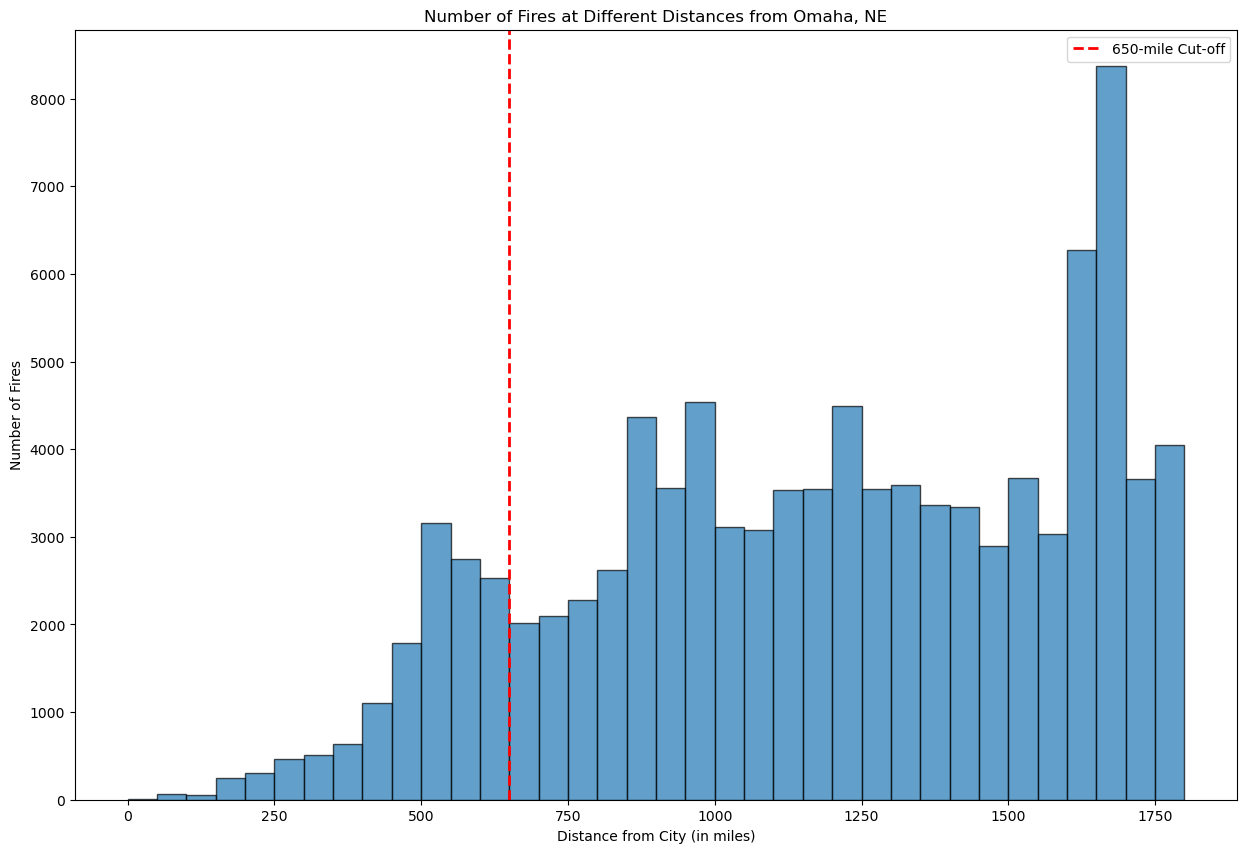

In [39]:
# Create a histogram with bins of size 50 miles up to 1800 miles
bin_size = 50
max_distance = 1800
bins = range(0, max_distance + bin_size, bin_size)

# Create the histogram
plt.figure(figsize=(15,10))
plt.hist(fires1800['distance_miles'], bins=bins, edgecolor='black', alpha=0.7)

# Add a line for the 650-mile distance cut-off
plt.axvline(x=650, color='r', linestyle='--', linewidth=2, label='650-mile Cut-off')

# Add labels and title
plt.xlabel('Distance from City (in miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires at Different Distances from Omaha, NE')
plt.legend()

# Display the plot
plt.show()

#### Visualization 2: Time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

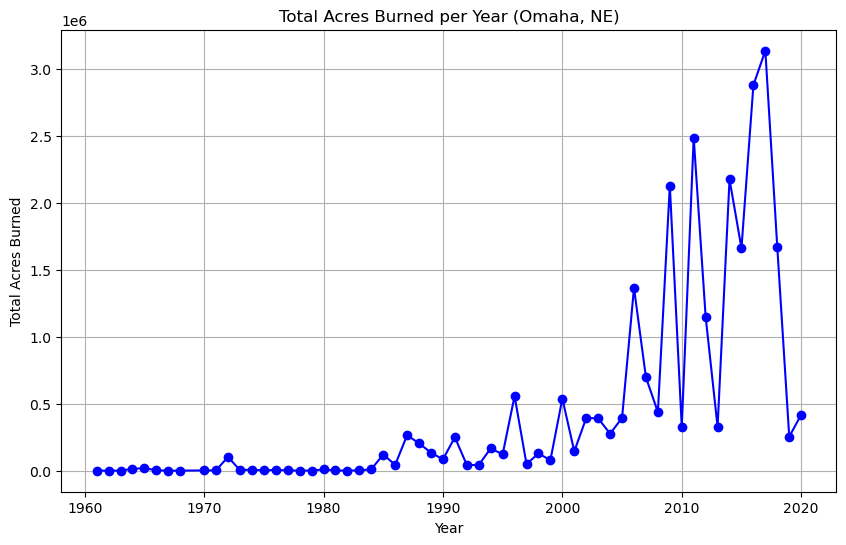

In [40]:
# Group data by year and sum the 'GIS_ACRES' column
burnt_acres_per_year = filtered_fires.groupby('Fire_Year')['GIS_Acres'].sum()

# Create the time series plot
plt.figure(figsize=(10, 6))
plt.plot(burnt_acres_per_year.index, burnt_acres_per_year.values, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned per Year (Omaha, NE)')
plt.grid(True)

# Show the plot
plt.show()

#### Visualization 3: Time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.

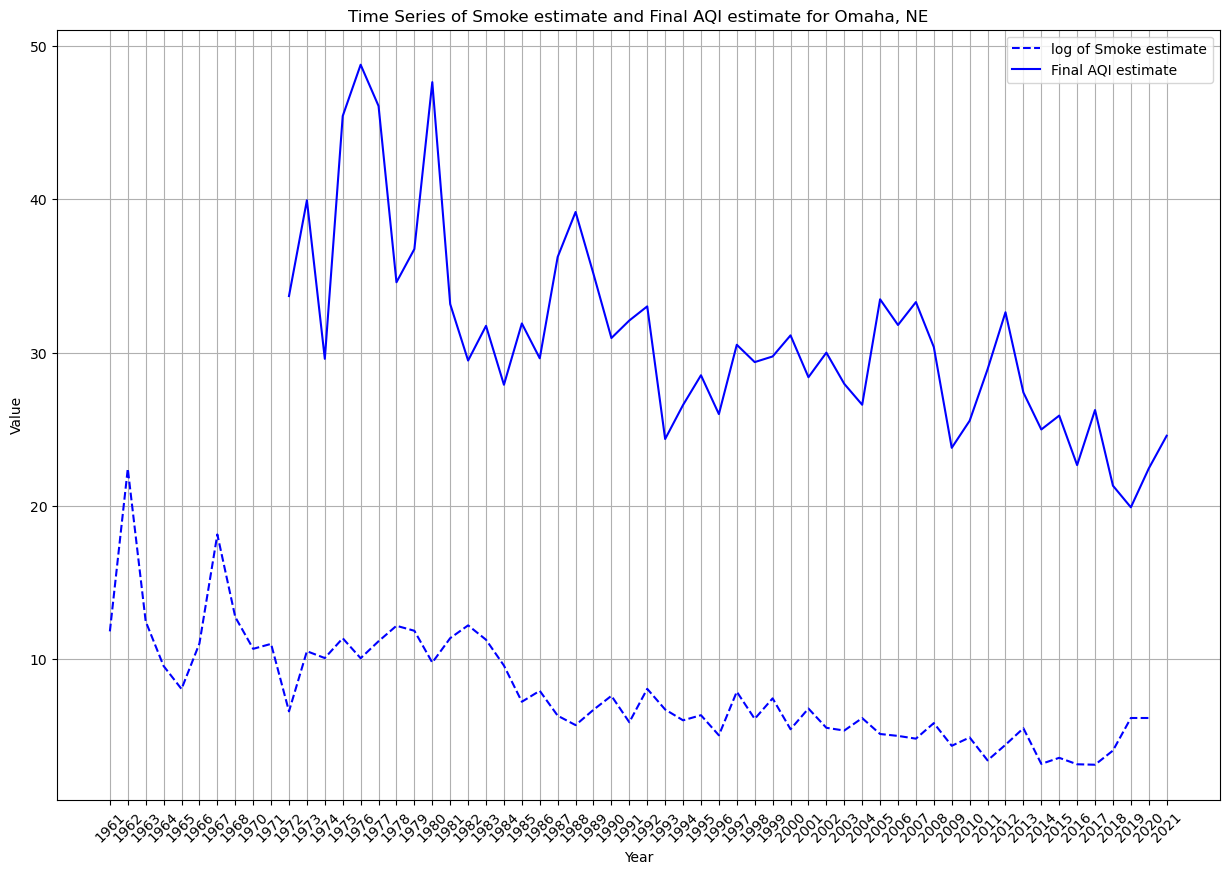

In [41]:
# Plotting final smoke estimate and final aqi estimate as time series plot

# Set up the figure
plt.figure(figsize=(15, 10))
# Plot the Smoke Estimate
plt.plot(annual_estimate['Fire_Year'], annual_estimate['log_smoke_estimate'], label='log of Smoke estimate', color='b', linestyle='--')

#Plot AQI estimate
plt.plot(aqi_data['year'], aqi_data['final_aqi'], label='Final AQI estimate', color='b')

# Set plot labels
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Time Series of Smoke estimate and Final AQI estimate for Omaha, NE')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.show()